In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import linalg as LA
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np

In [15]:
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=10,
                       lr=0.001, momentum=0.5, seed=1, log_interval=100)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [16]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

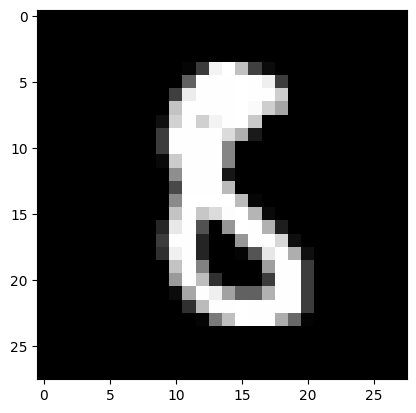

In [17]:
data, train_labels = next(iter(train_loader))
show_img = data[1][0].numpy()
input_dim = data[1].shape[1] * data[1].shape[2]
plt.imshow(show_img, cmap='gray')
plt.show()

In [60]:
class NeuralNet(nn.Module):
    def __init__(self, size=1600):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_dim, size, bias=True)
        self.linear2 = nn.Linear(size, 10)

    def forward(self, x):
        x = F.sigmoid(self.linear1(x))
        x = F.log_softmax(self.linear2(x), dim=1)
        return x

In [61]:
class SmoothSailing(nn.Module):
    def __init__(self, beta=0):
        super(SmoothSailing, self).__init__()
        self.loss = nn.CrossEntropyLoss()
        self.beta = beta

    def forward(self, inputs, targets, W=None):
        base_loss = self.loss(inputs, targets)

        if W is None or self.beta == 0:
            return base_loss
        else:
            W_norm = LA.norm(W, 2)**2
            W_fro = LA.norm(W, 'fro')**2 / W.shape[0]
            reg_loss = base_loss + self.beta * 0.5 * (W_norm - W_fro)
            return base_loss, reg_loss

        

In [62]:
def kappa(W):
    W_max = LA.norm(W, 2)
    W_min = LA.norm(LA.pinv(W), 2)
    return W_max * W_min 

In [63]:
torch.manual_seed(args.seed)
model = NeuralNet().to(device)
sail = SmoothSailing(beta=0)
optimizer = optim.Adam(model.parameters(), lr=args.lr)

torch.manual_seed(args.seed)
model_reg = NeuralNet().to(device)
smoothsail = SmoothSailing(beta=1)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=args.lr)
#optim.SGD(model_reg.parameters(), lr=args.lr, momentum=args.momentum)

In [64]:
fit = []
fit_val = []
fit_reg = []
fit_reg_val = []
acc = []
acc_reg = []
cond = []
cond_reg = []

W = model.linear1.weight.data
cond.append(kappa(W))

W_reg = model_reg.linear1.weight.data
cond_reg.append(kappa(W_reg))

print(f"Init condition numbers:")
print(f"\tBaseline condition number {cond[-1]:.2f}")
print(f"\tReguarized condition number {cond_reg[-1]:.2f}")

# train and evaluate

for epoch in range(args.epochs):
    running_loss = 0.0
    running_loss_reg = 0.0

    running_val_loss = 0.0
    running_val_loss_reg = 0.0

    model.train()
    model_reg.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, input_dim))
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = sail(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output_reg = model_reg(data)
        W = model_reg.linear1.weight
        loss_bas, loss_reg = smoothsail(output_reg, target, W)
        optimizer_reg.zero_grad()
        loss_reg.backward()
        optimizer_reg.step()

        running_loss += loss.item()
        running_loss_reg += loss_bas.item()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss_reg: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss_bas.item()))


    model.eval()
    model_reg.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data = Variable(data.view(-1, input_dim))
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = sail(output, target)

            output_reg = model_reg(data)
            W = model_reg.linear1.weight
            loss_bas, loss_reg = smoothsail(output_reg, target, W)

            running_val_loss += loss.item()
            running_val_loss_reg += loss_bas.item()

            pred = output.max(1, keepdim=True)[1]
            pred_reg = output_reg.max(1, keepdim=True)[1]
            accur = pred.eq(target.view_as(pred)).sum().item()
            accur_reg = pred_reg.eq(target.view_as(pred_reg)).sum().item()


    W = model.linear1.weight.data
    cond.append(kappa(W))
    W_reg = model_reg.linear1.weight.data
    cond_reg.append(kappa(W_reg))

    fit.append(running_loss/len(test_loader.dataset))
    fit_val.append(running_val_loss/args.test_batch_size)
    fit_reg.append(running_loss_reg/len(test_loader.dataset))
    fit_reg_val.append(running_val_loss_reg/args.test_batch_size)

    acc.append(accur/args.test_batch_size*100)
    acc_reg.append(accur_reg/args.test_batch_size*100)


    print(f"Epoch {epoch+1}/{args.epochs}:")
    print(f"\tLoss: {fit[-1]:.2f} with condition number {cond[-1]:.2f}")
    print(f"\tRegularized Loss: {fit_reg[-1]:.2f} with condition number {cond_reg[-1]:.2f}")
    print(f"\tAccuracy: {acc[-1]:.2f}%")
    print(f"\tRegularized Accuracy: {acc_reg[-1]:.2f}%")

Init condition numbers:
	Baseline condition number 5.76
	Reguarized condition number 5.76
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.327024	Loss_reg: 2.327024
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.330098	Loss_reg: 0.739837
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.497563	Loss_reg: 0.875772
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.235486	Loss_reg: 0.537437


KeyboardInterrupt: 

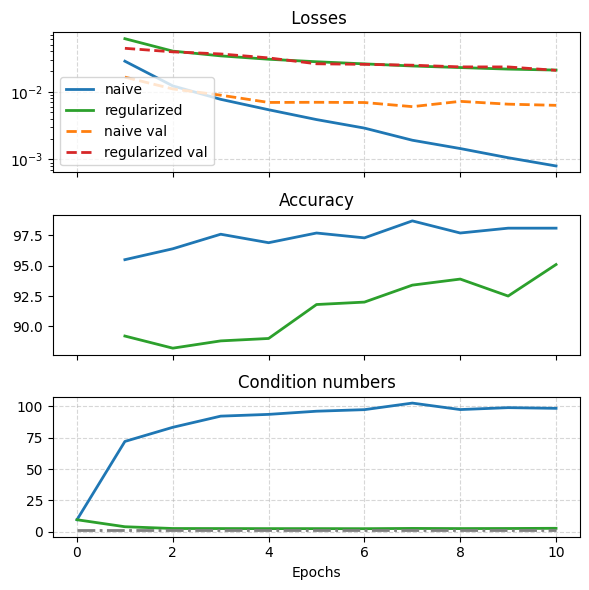

In [44]:
plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
Ts = np.arange(0, args.epochs+1)

ax = axes[0]
ax.plot(Ts[1:], fit, 'tab:blue', linewidth=2, label='naive')
ax.plot(Ts[1:], fit_reg, 'tab:green', linewidth=2, label='regularized')
ax.plot(Ts[1:], fit_val, 'tab:orange', linewidth=2, linestyle='--', label='naive val')
ax.plot(Ts[1:], fit_reg_val, 'tab:red', linewidth=2, linestyle='--', label='regularized val')

ax.set_yscale('log')
ax.set_title(' Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts[1:], acc, 'tab:blue', linewidth=2, label='naive')
ax.plot(Ts[1:], acc_reg, 'tab:green', linewidth=2, label='regularized')
ax.set_title('Accuracy')

ax = axes[2]
ax.plot(Ts, cond, 'tab:blue', linewidth=2)
ax.plot(Ts, cond_reg, 'tab:green', linewidth=2)
ax.plot(Ts, np.ones(len(Ts)), 'tab:gray', linewidth=2, label='Tightened', linestyle='-.')
#ax.set_yscale('log')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='lower left')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Fit_MNIST.pdf', bbox_inches='tight')